# Training GCN LSTM AE

This notebook shows how to train the anomaly detection model.

In [8]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import SpatioTemporalAutoencoder
from parameters import STAEParameters, TrainingParameters
from datautils import get_morning_data, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_stae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc, discrete_fp_delays_loc
import torch.nn as nn
from tqdm import tqdm

import random
import os
import torch_geometric
seed=42
torch_geometric.seed_everything(seed)

In [9]:
hide_anomalies = True

In [10]:
# study.trials_dataframe()['datetime_complete'].max()-study.trials_dataframe()['datetime_start'].min()

### Time Series Sequencing

In [11]:
def sequence_stae(data, timesteps, hide_anomalies=False):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(Data(x=torch.tensor(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy(), dtype=torch.float32), edge_index=static_edges)) # assumes time indices come sequentially, with full data it may not

        curr_graph = data_t[0]
        sequence.append([data_t[::-1], curr_graph])

    return sequence, kept_indices

### Loading Hyperparameters

In [12]:
optimal_hyperparams = load_best_parameters('gcn_lstm',hide_anomalies=hide_anomalies)

In [13]:
optimal_hyperparams

{'dropout': 0.3863112682928235,
 'epochs': 7,
 'gcn_hidden_dim': 256,
 'latent_dim': 128,
 'learning_rate': 9.299411313576956e-05,
 'lstm_hidden_dim': 32,
 'lstm_num_layers': 2,
 'timesteps': 10}

In [14]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [15]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=optimal_hyperparams['timesteps'],
    n_epochs=optimal_hyperparams['epochs'],
)

In [16]:
hyperparams = STAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    lstm_hidden_dim=optimal_hyperparams['lstm_hidden_dim'],
    lstm_num_layers=optimal_hyperparams['lstm_num_layers'],
    dropout=optimal_hyperparams['dropout']
)

In [17]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_stae(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_stae(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)


100%|██████████| 2870/2870 [00:14<00:00, 193.44it/s]


### Model Training or Loading

In [18]:
using_pretrained = True

In [19]:

if not using_pretrained:
    ae, losses = train_stae(staeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True, full_data=True)
    save_model(ae, f'stae_{hide_anomalies}_{seed}')
else:
    ae = load_model(SpatioTemporalAutoencoder, hyperparams, f'stae_{hide_anomalies}_{seed}')

In [20]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [21]:
thresh = compute_anomaly_threshold_rstae(val_sequence, ae, mse_weights, 'max')

100%|██████████| 1209/1209 [00:13<00:00, 91.78it/s]


### Loading Test Data

In [22]:
_, df_test_data, _ = get_full_data()

In [23]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_stae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4790/4790 [00:41<00:00, 115.22it/s]


In [24]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [25]:
test_errors.shape

(4745, 196)

In [40]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
# crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [41]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]



/tmp/ipykernel_533624/3884504702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['Time']=converted_dates_naive
/tmp/ipykernel_533624/3884504702.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_events['Time'] = pd.to_datetime(test_events['Time'])
/tmp/ipykernel_533624/3884504702.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [42]:
path_results = 'saved_results/gcn_lstm/'
results = discrete_fp_delays_loc(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
# results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)




100%|██████████| 1000/1000 [00:28<00:00, 34.85it/s]

Found FPR of 0.010025062656641603 for 0.01
Found FPR of 0.024644945697577275 for 0.025
Found FPR of 0.05012531328320802 for 0.05
Found FPR of 0.09941520467836257 for 0.1
Found FPR of 0.1996658312447786 for 0.2
FPR 1% gives mean delay of -3.0833333333333335 +/- 10.084710649735513 with mean. distance of 2.8388888888888886 +/- 1.7181672693402406 while missing 0.4%.
FPR 2.5% gives mean delay of -6.571428571428571 +/- 10.331742251875221 with mean. distance of 3.1149999999999998 +/- 2.457239304585534 while missing 0.30000000000000004%.
FPR 5% gives mean delay of -10.5 +/- 5.9281411203561225 with mean. distance of 3.08 +/- 2.4689268923967758 while missing 0.30000000000000004%.
FPR 10% gives mean delay of -13.142857142857142 +/- 1.976907500442578 with mean. distance of 3.2375 +/- 2.8294673379748825 while missing 0.30000000000000004%.
FPR 20% gives mean delay of -11.9 +/- 3.8910152916687437 with mean. distance of 2.160869565217391 +/- 2.4284973221843025 while missing 0.0%.


In [21]:
#SAVING RESULTS
calculate_auc(test_errors,anomaly_labels)

# 100%|██████████| 1000/1000 [00:28<00:00, 34.85it/s]Found FPR of 0.00997506234413965 for 0.01
# Found FPR of 0.02493765586034913 for 0.025
# Found FPR of 0.04987531172069826 for 0.05
# Found FPR of 0.09891936824605153 for 0.1
# Found FPR of 0.20116375727348296 for 0.2
# FPR 1% gives mean delay of -0.375 +/- 7.833222516946649 while missing 0.33333333333333337%.
# FPR 2.5% gives mean delay of -7.666666666666667 +/- 6.411794687223782 while missing 0.25%.
# FPR 5% gives mean delay of -7.2272727272727275 +/- 5.793270533219934 while missing 0.08333333333333337%.
# FPR 10% gives mean delay of -10.666666666666666 +/- 4.963757537278476 while missing 0.0%.
# FPR 20% gives mean delay of -12.958333333333334 +/- 1.8080644961455945 while missing 0.0%.




0.6906653120285705

In [44]:
hide_anomalies

True

Spatial Localization

In [22]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

/tmp/ipykernel_3874500/527824920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['Time']=converted_dates_naive


In [ ]:
import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]



/tmp/ipykernel_3874500/20370410.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_events['Time'] = pd.to_datetime(test_events['Time'])
/tmp/ipykernel_3874500/20370410.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
/tmp/ipykernel_3874500/20370410.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [25]:
def crash_detection_delay_loc(anomaly_pred, crash_reported, sr=0.5):
    time_anomalies = np.any(anomaly_pred==1, axis=1)
    spac_pred = np.any(anomaly_pred.reshape(-1, 49, 4)==1, axis=2)
    space_anomalies = np.any(crash_reported.reshape(-1, 49, 4)==1, axis=2)
    delay = []
    detects = []
    localizations = []
    
    reported_indices = np.unique(np.where(crash_reported == 1)[0])
    for i in reported_indices:
        detected = False
        for t in range(int(i-(15/sr)), int(i+(15/sr))):
            if t >= len(time_anomalies):
                detected = False
                break
            if time_anomalies[t] == 1:
                delay.append(t-i)
                anom_indices=np.where(space_anomalies[i]==1)[0]
                pred_indices=np.where(spac_pred[t]==1)[0]
                distances = np.abs(anom_indices[:, None] - pred_indices[None, :])

                # Find the mean distance
                
                localizations.append(distances.flatten())
                
                
                
                detected = True
                break
            
        detects.append(detected)
    all_distances = np.concatenate(localizations) if localizations else np.array([])

    
    return delay, detects, all_distances

In [27]:
thresholds = find_thresholds(thresh, test_errors, anomaly_labels) #thresholds[:,0] is the fpr

fprs = [1, 2.5, 5, 10, 20]
new_thresholds = []
for fpr in fprs:
    new_thresholds.append(find_percent(thresholds, fpr))

anomaly_instances = []
for t in new_thresholds:
    anomaly_instances.append(threshold_anomalies(thresh+t, test_errors))
    
results=[]
for i, fpr in enumerate(fprs):
    delay, found, distances = crash_detection_delay_loc(anomaly_instances[i], crash_reported, sr=0.5)
    mu = np.mean(delay) * 0.5
    std = np.std(delay) * 0.5
    mu_dist = np.mean(distances)
    std_dist = np.std(distances)
    miss_percent = 1-(np.sum(found) / len(found))
    
    results.append([fpr, mu, std, miss_percent, mu_dist, std_dist])
    print(f'FPR {fpr}% gives mean delay of {mu} +/- {std} with mean. distance of {mu_dist*0.35} +/- {std_dist*0.35} while missing {miss_percent}%.')
    # break
results_df = pd.DataFrame(results, columns=['FPR (%)', 'Mean Delay', 'Std Delay', 'Miss Percentage', 'Mean Distance', 'Std Distance'])



100%|██████████| 1000/1000 [00:28<00:00, 35.00it/s]

Found FPR of 0.00997506234413965 for 0.01
Found FPR of 0.02493765586034913 for 0.025
Found FPR of 0.04987531172069826 for 0.05
Found FPR of 0.09891936824605153 for 0.1
Found FPR of 0.20116375727348296 for 0.2
FPR 1% gives mean delay of 0.14285714285714285 +/- 8.2449737317189 with mean. distance of 3.01 +/- 3.9043437348676147 while missing 0.30000000000000004%.
FPR 2.5% gives mean delay of -9.785714285714286 +/- 5.350948800093726 with mean. distance of 3.8499999999999996 +/- 3.4904414933045103 while missing 0.30000000000000004%.
FPR 5% gives mean delay of -8.0 +/- 6.141841924229427 with mean. distance of 3.4461538461538463 +/- 3.342584302973555 while missing 0.09999999999999998%.
FPR 10% gives mean delay of -11.15 +/- 4.863383595810637 with mean. distance of 3.040625 +/- 2.46780638612007 while missing 0.0%.
FPR 20% gives mean delay of -13.2 +/- 1.8055470085267789 with mean. distance of 2.614705882352941 +/- 2.4576869030645074 while missing 0.0%.


FPR 1% gives mean delay of 0.14285714285714285 +/- 8.2449737317189 with mean. distance of 3.01 +/- 3.9043437348676147 while missing 0.30000000000000004%.
FPR 2.5% gives mean delay of -9.785714285714286 +/- 5.350948800093726 with mean. distance of 3.8499999999999996 +/- 3.4904414933045103 while missing 0.30000000000000004%.
FPR 5% gives mean delay of -8.0 +/- 6.141841924229427 with mean. distance of 3.4461538461538463 +/- 3.342584302973555 while missing 0.09999999999999998%.
FPR 10% gives mean delay of -11.15 +/- 4.863383595810637 with mean. distance of 3.040625 +/- 2.46780638612007 while missing 0.0%.
FPR 20% gives mean delay of -13.2 +/- 1.8055470085267789 with mean. distance of 2.614705882352941 +/- 2.4576869030645074 while missing 0.0%.


In [105]:
np.concatenate(distances)

array([[ 5],
       [ 4],
       [38],
       [20],
       [ 1],
       [ 2],
       [ 7],
       [ 6],
       [ 0],
       [ 3]])

In [97]:
distances

[array([[5],
        [4]]),
 array([[38]]),
 array([[20]]),
 array([[1],
        [2]]),
 array([[7],
        [6]]),
 array([[0]]),
 array([[3]])]

In [52]:
reported_indices = np.where(crash_reported == 1)[0]

In [53]:
reported_indices

array([ 274,  274,  274,  274,  274,  274,  274,  274, 2218, 2218, 2218,
       2218, 2341, 2341, 2341, 2341, 2403, 2403, 2403, 2403, 2403, 2403,
       2403, 2403, 2564, 2564, 2564, 2564, 2564, 2564, 2564, 2564, 2766,
       2766, 2766, 2766, 3681, 3681, 3681, 3681, 3681, 3681, 3681, 3681,
       3730, 3730, 3730, 3730, 3730, 3730, 3730, 3730, 4453, 4453, 4453,
       4453, 4515, 4515, 4515, 4515])

In [ ]:


def generate_anomaly_labels_node_level(test_data, kept_indices, node_column='milemarker'):
    unix_times = np.unique(test_data['unix_time'])
    test_data = test_data[test_data['unix_time'].isin(unix_times[kept_indices])]
    
    # Label anomalies based on human-labeled events at each node (mile marker)
    human_label_times = test_data[test_data['human_label'] == 1][['unix_time', node_column]].drop_duplicates()
    for _, row in human_label_times.iterrows():
        human_label_time = row['unix_time']
        node = row[node_column]
        test_data.loc[
            (test_data['unix_time'] - human_label_time <= 1800) & 
            (test_data['unix_time'] - human_label_time >= 0) & 
            (test_data[node_column] == node), 
            'anomaly'
        ] = 1
    
    # Label anomalies based on crash records at each node (mile marker)
    crash_label_times = test_data[test_data['crash_record'] == 1][['unix_time', node_column]].drop_duplicates()
    
    for _, row in crash_label_times.iterrows():
        crash_label_time = row['unix_time']
        node = row[node_column]
        test_data.loc[
            (test_data['unix_time'] - crash_label_time <= 900) & 
            (test_data['unix_time'] - crash_label_time >= -900) & 
            (test_data[node_column] == node), 
            'anomaly'
        ] = 1

    incident_times = np.unique(test_data[(test_data['human_label']==1) | (test_data['crash_record']==1)]['unix_time'])
    for incident_time in incident_times:
        test_data.loc[(test_data['unix_time'] - incident_time <= 6300) & (test_data['unix_time'] - incident_time >= 900), 'anomaly'] = -1
    
    test_data.fillna(0, inplace=True)

    return test_data


def generate_anomaly_labels_spatial(test_data, kept_indices):
    unix_times = np.unique(test_data['unix_time'])
    test_data = test_data[test_data['unix_time'].isin(unix_times[kept_indices])]
    human_label_times = np.unique(test_data[test_data['human_label']==1]['unix_time'])
    for human_label_time in human_label_times:
        test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1

    crash_label_times = np.unique(test_data[test_data['crash_record']==1]['unix_time'])
    for crash_label_time in crash_label_times:
        test_data.loc[(test_data['unix_time'] - crash_label_time <= 900) & (test_data['unix_time'] - crash_label_time >= -900), 'anomaly'] = 1

    incident_times = np.unique(test_data[(test_data['human_label']==1) | (test_data['crash_record']==1)]['unix_time'])
    for incident_time in incident_times:
        test_data.loc[(test_data['unix_time'] - incident_time <= 6300) & (test_data['unix_time'] - incident_time >= 900), 'anomaly'] = -1
    
    test_data.fillna(0, inplace=True)

    return test_data

In [45]:
spatial_anomaly_labels = generate_anomaly_labels_node_level(df_test_data, kept_test_indices)


         unix_time  milemarker
340550  1697021700        53.3
340551  1697021700        53.6
340552  1697021700        53.9
340553  1697021700        54.1
340554  1697021700        54.6
...            ...         ...
485144  1697455800        68.5
485145  1697455800        68.8
485146  1697455800        69.3
485147  1697455800        69.8
485148  1697455800        70.1

[392 rows x 2 columns]


/tmp/ipykernel_2133494/564281729.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[
/tmp/ipykernel_2133494/564281729.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [23]:
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [26]:
crash_reported

array([0, 0, 0, ..., 0, 0, 0])

### Compute FPR / Crash Detection Delay Tradeoff

In [26]:
import importlib
import metrics
importlib.reload(metrics)
delay_results = np.array(metrics.find_delays(thresh, test_errors, anomaly_labels, crash_reported))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 98/98 [00:00<00:00, 200.48it/s]


In [27]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/stae_fp_delay.csv')

In [28]:
delay_df.sort_values(by='Mean Delay')

,FPR,Mean Delay,Std Delay,Found Percent
99,1.000000,-30.000000,0.000000,1.000000
73,0.737739,-30.000000,0.000000,1.000000
72,0.726101,-30.000000,0.000000,1.000000
71,0.719036,-30.000000,0.000000,1.000000
70,0.707814,-30.000000,0.000000,1.000000
...,...,...,...,...
4,0.040316,-19.000000,15.779734,0.833333
3,0.030341,-16.888889,17.239776,0.750000
2,0.019950,-10.875000,18.943584,0.666667
1,0.010391,-6.428571,18.676625,0.583333


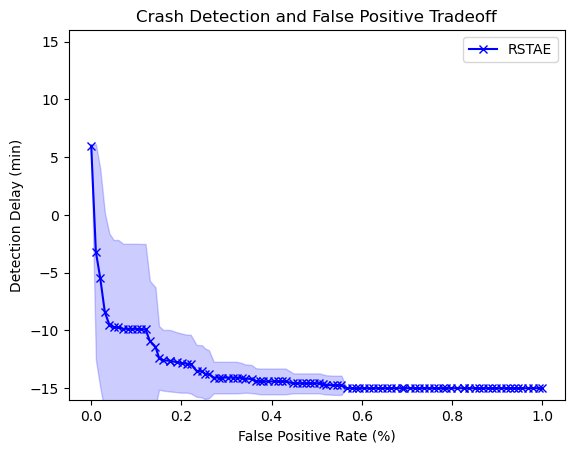

In [29]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [30]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [00:31<00:00, 31.89it/s]

Found FPR of 0.010390689941812137 for 0.01
Found FPR of 0.02493765586034913 for 0.025
Found FPR of 0.04987531172069826 for 0.05
Found FPR of 0.10099750623441396 for 0.1
Found FPR of 0.20116375727348296 for 0.2
FPR 1% gives mean delay of -3.2142857142857144 +/- 9.33831256880241 while missing 0.41666666666666663%.
FPR 2.5% gives mean delay of -7.0 +/- 8.488554385497896 while missing 0.25%.
FPR 5% gives mean delay of -9.727272727272727 +/- 7.5569463420437835 while missing 0.08333333333333337%.
FPR 10% gives mean delay of -9.863636363636363 +/- 7.36419750948314 while missing 0.08333333333333337%.
FPR 20% gives mean delay of -12.833333333333334 +/- 2.5603819159562025 while missing 0.0%.


### Compute AUC

In [21]:
calculate_auc(test_errors, anomaly_labels)

0.6725597429788462

In [56]:
anomaly_labels.shape

(932372,)

### Copmute Detection Delay Histogram on Full Dataset

In [32]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [33]:
full_sequence, kept_full_indices = sequence_stae(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 10/18232 [00:00<03:25, 88.67it/s]

100%|██████████| 18232/18232 [04:49<00:00, 62.98it/s]


In [34]:
full_errors, _, _ = test_rstae(full_sequence, mse_weights, ae)

In [35]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [36]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [01:56<00:00,  8.61it/s]


In [37]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


Found FPR of 0.10149359049747148 for 0.1


In [38]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

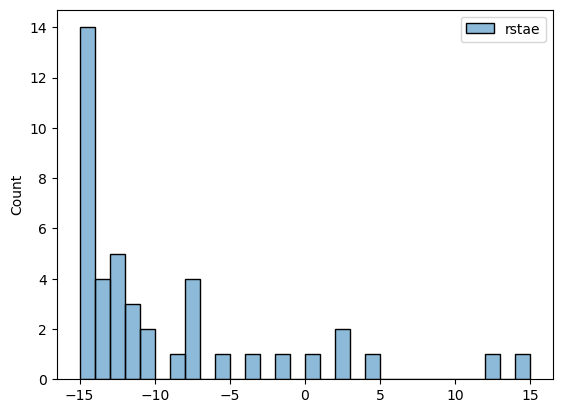

In [39]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='rstae')
plt.legend()

In [40]:
np.save('./saved_results/stae10delays.npy', np.array(delay)/2)

In [41]:
_, df_clean_test_data, _ = get_full_data()

In [42]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_stae(clean_test_data, training_params.timesteps, hide_anomalies=True)

  0%|          | 0/4792 [00:00<?, ?it/s]

100%|██████████| 4792/4792 [00:26<00:00, 179.11it/s]


In [43]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_rstae(clean_test_data, mse_weights, ae)

In [44]:
np.mean(clean_test_errors)

0.011401049

In [45]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [46]:
# data.to_csv('./saved_results/full_results_test_rstae.csv')

In [47]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_rstae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [48]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [49]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [7]:
import optuna   
import pandas as pd

study = optuna.study.load_study(
            study_name='TRACE_TG',  # Replace with your study name
            storage=f"sqlite:///studies_non_hide/TRACE_TG.db")
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate,params_epochs,params_flow_layers,params_hidden_dim,params_learning_rate,params_n_hidden_flow,params_num_gcn_layers,params_num_transformer_layers,params_output_dim,params_timesteps,state
0,0,1.869905e+02,2024-11-25 17:02:00.461837,2024-11-25 19:09:38.225282,0 days 02:07:37.763445,0.016374,8,3,64,0.000002,1,2,2,64,3,COMPLETE
1,1,-4.549376e+00,2024-11-25 22:16:25.704920,2024-11-26 00:32:15.038976,0 days 02:15:49.334056,0.335803,5,2,256,0.000003,4,1,1,64,5,COMPLETE
2,2,-3.168887e+01,2024-11-25 22:16:25.790262,2024-11-26 01:05:16.072673,0 days 02:48:50.282411,0.341284,5,4,16,0.000004,4,5,1,32,10,COMPLETE
3,3,-2.092916e+01,2024-11-26 00:32:15.133354,2024-11-26 02:38:16.167430,0 days 02:06:01.034076,0.292964,7,4,64,0.000040,1,2,2,128,3,COMPLETE
4,4,7.191986e+05,2024-11-26 01:05:16.177481,2024-11-26 03:41:23.810708,0 days 02:36:07.633227,0.018475,5,1,16,0.000093,1,5,1,64,10,COMPLETE
5,5,-8.097610e-01,2024-11-26 02:38:16.261178,2024-11-26 04:03:41.026855,0 days 01:25:24.765677,0.020236,3,3,16,0.000127,4,1,2,128,8,COMPLETE
6,6,1.180272e+01,2024-11-26 03:41:23.916641,2024-11-26 06:26:45.606140,0 days 02:45:21.689499,0.204185,8,5,128,0.000001,1,4,1,64,4,COMPLETE
7,7,inf,2024-11-26 04:03:41.119619,2024-11-26 04:17:42.916629,0 days 00:14:01.797010,0.174938,7,4,256,0.007500,5,5,2,32,6,COMPLETE
8,8,-1.567735e+01,2024-11-26 04:17:43.017186,2024-11-26 07:15:29.225110,0 days 02:57:46.207924,0.402693,8,1,256,0.000274,4,1,2,64,4,COMPLETE
9,9,-2.919407e+00,2024-11-26 06:26:45.700439,2024-11-26 10:12:28.123557,0 days 03:45:42.423118,0.042884,9,5,128,0.000011,3,5,2,64,2,COMPLETE
